# ECI 2018 Lab 1: Linear encoding models for responses to speech # 

Author: Liberty Hamilton

July 2018

This jupyter notebook tutorial will explain how to calculate linear receptive field models and time-delayed linear models for spectrotemporal, phoneme, and phonetic feature models. 

## How to use this notebook: ## 

This notebook is split up into a number of different sections, starting with showing the stimulus feature representations and neural data, and eventually running ridge regression analysis using different regularization parameters.  To run each cell, click in the cell and press "shift-Enter".  You can also edit the code inline and re-run anything you wish.

If you need more practice with python, check the IntroToPython.ipynb notebook first.

**References:**

* Aertsen & Johannesma (1981). The spectro-temporal receptive field.  Biological Cybernetics 42, 133-143. http://hearingbrain.org/docs/AertsenSTRF_1981.pdf
* Theunissen, David, Singh et al. (2001). Estimating spatio-temporal receptive fields of auditory and visual neurons from their responses to natural stimuli. Network 2001, 12:3 289-316. http://www.maths.tcd.ie/~mnl/store/TheunissenEtAl2001a.pdf
* Wu, David, Gallant (2006). Complete functional characterization of sensory neurons by system identification.  Annu Rev Neurosci 29: 477-505. http://suns.mit.edu/2006.Wu.David.Gallant.pdf
* Holdgraf et al. (2017). Encoding and Decoding Models in Cognitive Electrophysiology. Frontiers in Systems Neuroscience. https://www.frontiersin.org/articles/10.3389/fnsys.2017.00061/full

## What is a spectrotemporal receptive field?
A spectrotemporal receptive field is a linear filter that describes which spectrotemporal features of a stimulus will increase or decrease activity in a neuron/electrode/recording site. For example, the figure below shows a spectrotemporal receptive field for an ECoG electrode that is selective for high frequency content associated with sounds like "sh" and "ss". 

## Ridge regression (in general) ##

The goal of ridge regression is to find a linear transformation of your feature matrix, $X$, that best approximates your observed data, $Y$. The linear transformation takes the form of a weight matrix, $B$, such that $X B = Y$.

In ridge regression, $B$ is obtained by taking the ridge pseudoinverse of $X$ and multiplying it by $Y$ ($\hat{B} = X^+ Y$). To get the ridge pseudoinverse we first take the Eigendecomposition of $X$: $X = U S U^{-1}$. For a normal pseudoinverse we would just invert the singular values (forming the inverse matrix $D$ by taking $1/S$ for each entry in $S$), but for a ridge pseudoinverse we regularize the inverse using a ridge penalty, $\alpha$. Thus we use $D_i = \frac{1}{(S_i + \alpha)}$. This fixes problems with very small eigenvalues, which would get very large in the inverse and mess things up.  

The key issue for doing ridge regression is choosing the right $\alpha$. For real-world data (which is autocorrelated and messy), this is usually done by testing many different possible values of a using cross validation. In cross validation the regression dataset is broken up into two parts, a training set and a test set. A separate weight matrix, $B$, is obtained for each value of a using the training set, and then that $B$ is used to predict the test set. 

This process is usually repeated a few times for a few different selections of training and test set. Then the best $\alpha$ is selected based on how well each $\alpha$ could be used to predict the test set.  


## The tutorial!

To use your own data, you will need:

- Your stimulus matrix (time x features).  This might be a spectrogram (time points x frequency bands, for example), or it might be a binary matrix for the presence/absence of phonemes or phonetic features (in that case, time points x  phonemes). It could also be just one feature you want to test (e.g. pitch, so the stimulus would be time points x 1 pitch channel).
- Your response matrix (time x electrodes).  This is your preprocessed, z-scored high gamma analytic amplitude (if using ECoG data).  It could also be preprocessed EEG data in a certain frequency band, a set of neuronal action potentials, or fMRI BOLD signals over time.   
- The file should also contain the sampling rate of the data as a variable "fs" (Here fs=100)

### Sample data: ###

We include data from several sources:

1. Electrocorticography data from a person listening to sentences from the TIMIT database: <tt>data/sample_stimresp.hf5</tt>
2. A fake dataset of simulated data: <tt>data/fakedata_stimresp.hf5</tt>.


In [1]:
# Import the modules we need, do some magic

# The first two lines here are a bit of "magic" for showing plots inline in the notebook
# (instead of opening a new window)
%pylab
%matplotlib inline

import tables # this is a library for loading hdf5 files
import scipy.io # For loading .mat files (usually from matlab)
import matplotlib.pyplot as plt # For plotting
import h5py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [4]:
# Choose which of these data files to use
model_type = 'spectrotemporal'
fit_phoneme_model = True


dataFile = 'data/sample_stim_waveform.hf5' # HDF5 file with our sound data
with tables.open_file(dataFile) as tf:
    soundstim = tf.root.soundstim.read() # Read the sound waveform
    sound_fs = tf.root.sound_fs.read() # Sampling frequency of the sound waveform data

dataFile = 'data/sample_stim_spec.hf5' # HDF5 file with our spectrogram data
with tables.open_file(dataFile) as tf: # open the data file
    audstim = tf.root.audstim.read() # Load the spectrogram matrix
    freqs = tf.root.freqs.read() # Center frequencies of spectrogram

dataFile = 'data/sample_stim_phn.hf5' # HDF5 file with our phoneme data
with tables.open_file(dataFile) as tf: # open the data file
    phnstim = tf.root.phnstim.read() # Load the binary phoneme presence/absence matrix (can use as stim instead)
    phonemes = tf.root.phonemes.read() # Phoneme labels

dataFile = 'data/sample_stim_feat.hf5' # HDF5 file with our phoneme feature data
with tables.open_file(dataFile) as tf: # open the data file
    featstim = tf.root.featstim.read() # Load the phoneme feature matrix (can use as stim instead)
    features = tf.root.feats.read() # Phonetic feature labels

dataFile = 'data/sample_stim_resp.hf5' # HDF5 file with our response data
with tables.open_file(dataFile) as tf: # open the data file
    resp = tf.root.resp.read() # Loads the high gamma data matrix 
    fs = tf.root.fs.read()[0] # Sampling rate of the data (resp, audstim, and phnstim)

nchans = resp.shape[1] # The number of channels (e.g. electrodes, neurons)

# Let's look at the dimensions of the stimulus matrix
print("Data file: %s\n"%(dataFile))
print("Possible feature representations:")
print("\tSpectrogram stimulus is %d time points x %d frequencies"%(audstim.shape))
print("\tPhoneme stimulus is %d time points x %d phonemes"%(phnstim.shape))
print("\tPhonetic feature stimulus is %d time points x %d features"%(featstim.shape))
print("Response is %d time points x %d channels\n"%(resp.shape))

print("Phonemes are ", [p.decode() for p in phonemes])
print("Features are ", [f.decode() for f in features])

Data file: data/sample_stim_resp.hf5

Possible feature representations:
	Spectrogram stimulus is 106299 time points x 80 frequencies
	Phoneme stimulus is 106299 time points x 59 phonemes
	Phonetic feature stimulus is 106299 time points x 14 features
Response is 106299 time points x 68 channels

Phonemes are  ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ax-h', 'axr', 'ay', 'b', 'bcl', 'ch', 'd', 'dcl', 'dh', 'dx', 'eh', 'el', 'em', 'en', 'eng', 'epi', 'er', 'ey', 'f', 'g', 'gcl', 'hh', 'hv', 'ih', 'ix', 'iy', 'jh', 'k', 'kcl', 'l', 'm', 'n', 'ng', 'nx', 'ow', 'oy', 'p', 'pcl', 'q', 'r', 's', 'sh', 't', 'tcl', 'th', 'uh', 'uw', 'ux', 'v', 'w', 'y', 'z', 'zh']
Features are  ['dorsal', 'coronal', 'labial', 'high', 'front', 'low', 'back', 'plosive', 'fricative', 'syllabic', 'nasal', 'voiced', 'obstruent', 'sonorant']


## TIMIT stimuli ##

In the sample dataset, neural activity was recorded using electrocorticography in one participant listening to sentences from the [TIMIT acoustic-phonetic database](https://catalog.ldc.upenn.edu/docs/LDC93S1/timit.readme.html).

If you'd like to listen to them, you can pass the vector `soundstim` to IPython's Audio function for any given time period.  Here, we'll play the first 10 seconds.

In [6]:
from IPython.display import Audio

# Play an excerpt of the sounds
Audio(data=soundstim[:np.int(sound_fs*10)], rate = np.int(sound_fs))

## Plot the stimulus and response

At this point, it's helpful to show what the stimuli and responses look like so we know what will go into our model.

You should also choose whether to Z-score your responses.  Here we implement a simple Z-score across the whole dataset.

In [7]:
# Run this if you have a Retina (Mac) or high resolution display, otherwise comment out
%config InlineBackend.figure_format = 'retina' 

In [8]:
# Z-score the response
# Make a zscoring function
zs = lambda x: (x-x.mean(0))/x.std(0) 

respz = zs(resp)

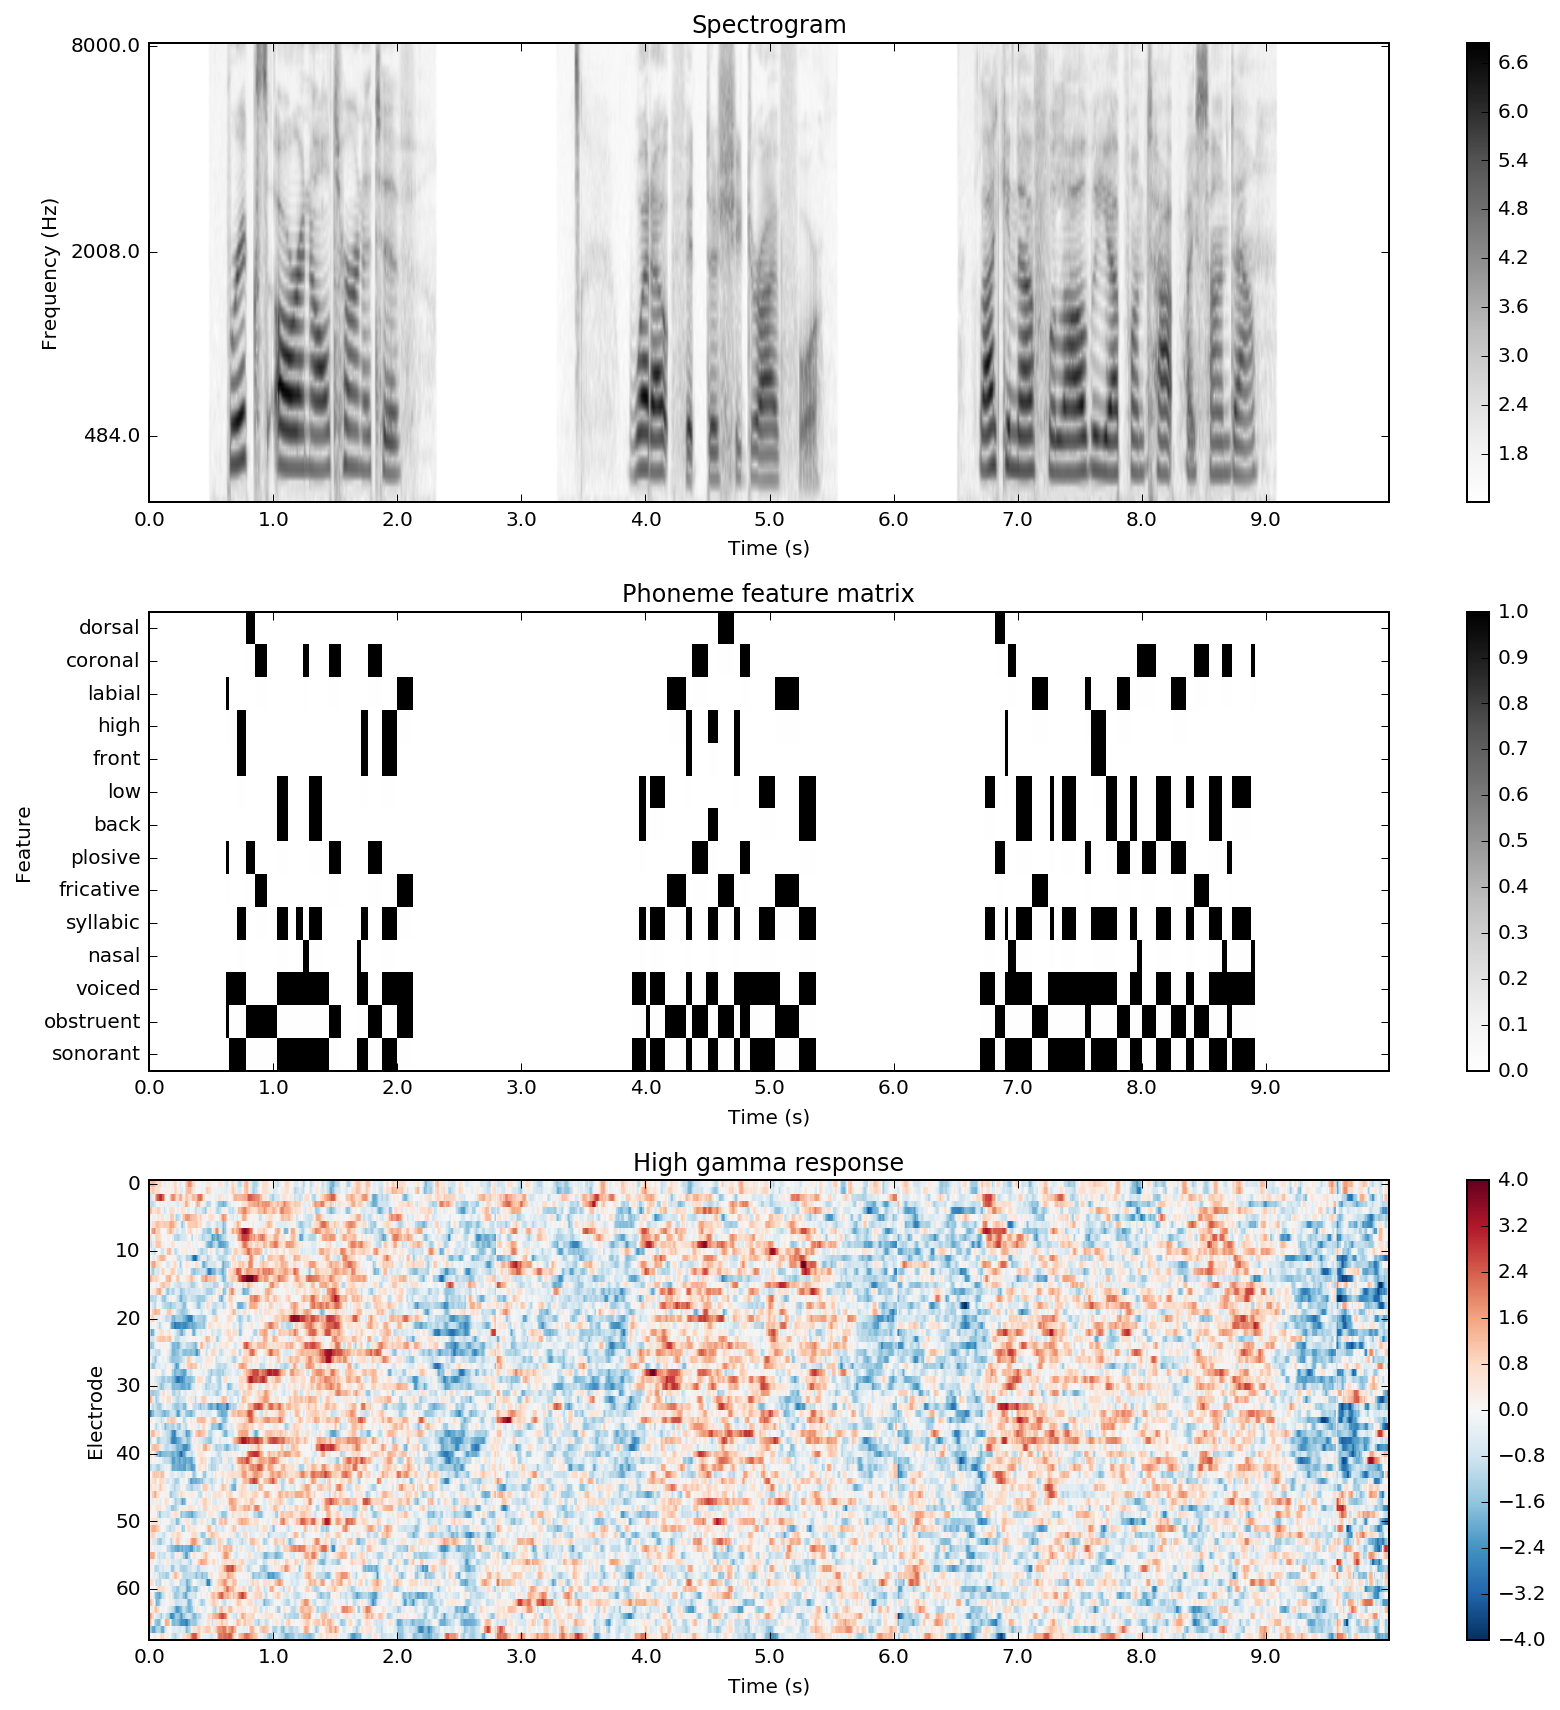

In [9]:
# Plot the stimulus and response to see what they look like

# Instead of plotting all ~100,000 time points, let's just plot a subset to get an idea
nsec = 10
ntimes = np.int(nsec*fs)

fig, axes = plt.subplots(figsize=(12,12)) # make a figure of size 12 x 8
ax = fig.add_subplot(3,1,1)
plt.imshow(audstim[:ntimes,:].T, cmap = cm.Greys, aspect='auto') # I transposed the matrix so time is on the x axis
ax.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
yticks([11,43,79], [np.round(freqs[f]) for f in [11,43,79]])
xticks(np.arange(0,ntimes,fs), np.arange(0, ntimes, fs)/fs)
xlabel('Time (s)')
ylabel('Frequency (Hz)')
plt.colorbar()
title('Spectrogram')

subplot(3,1,2)
plt.imshow(featstim[:ntimes,:].T, cmap = cm.Greys, aspect='auto', interpolation = 'none') # I transposed the matrix so time is on the x axis
yticks(np.arange(featstim.shape[1]), [p.decode() for p in features])
xticks(np.arange(0,ntimes,fs), np.arange(0, ntimes, fs)/fs)
xlabel('Time (s)')
ylabel('Feature')
plt.colorbar()
title('Phoneme feature matrix')

subplot(3,1,3)
if nchans>4: # For a large number of channels, show an image
    plt.imshow(resp[:ntimes,:].T, vmin=-4, vmax=4, cmap = cm.RdBu_r, aspect='auto', interpolation = 'none') 
    ylabel('Electrode')
else: # For a small number of channels, plot the time series
    plt.plot(resp[:ntimes,:]) 
    ylabel('Z')
xlabel('Time (s)')
xticks(np.arange(0,ntimes,fs), np.arange(0, ntimes, fs)/fs)
plt.colorbar()
title('High gamma response')

fig.tight_layout()
#fig.subplots_adjust(hspace=.5) # Put some space between the plots for ease of viewing

# Set some parameters for this and future plots
rcParams['font.family'] = 'sans-serif'
rcParams['text.usetex'] = False
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10

savefig("sample_stimresp.pdf")

## Neural responses to the stimuli

Next, we will plot some example single electrode responses.

In the cell below, we will also choose which stimulus representation will be used in the later analysis.  Since we're fitting a regression model predicting an electrode channel's activity (from the variable `resp`) from some acoustic or linguistic representation (from the variable `stim`), we will plot one of the stimulus presentations (the spectrogram) as well as some neural data.

In [10]:
feature_type = 'spectrogram' # this will be used to name the output file
stim = audstim # Here is where we decide which stimulus representation to use

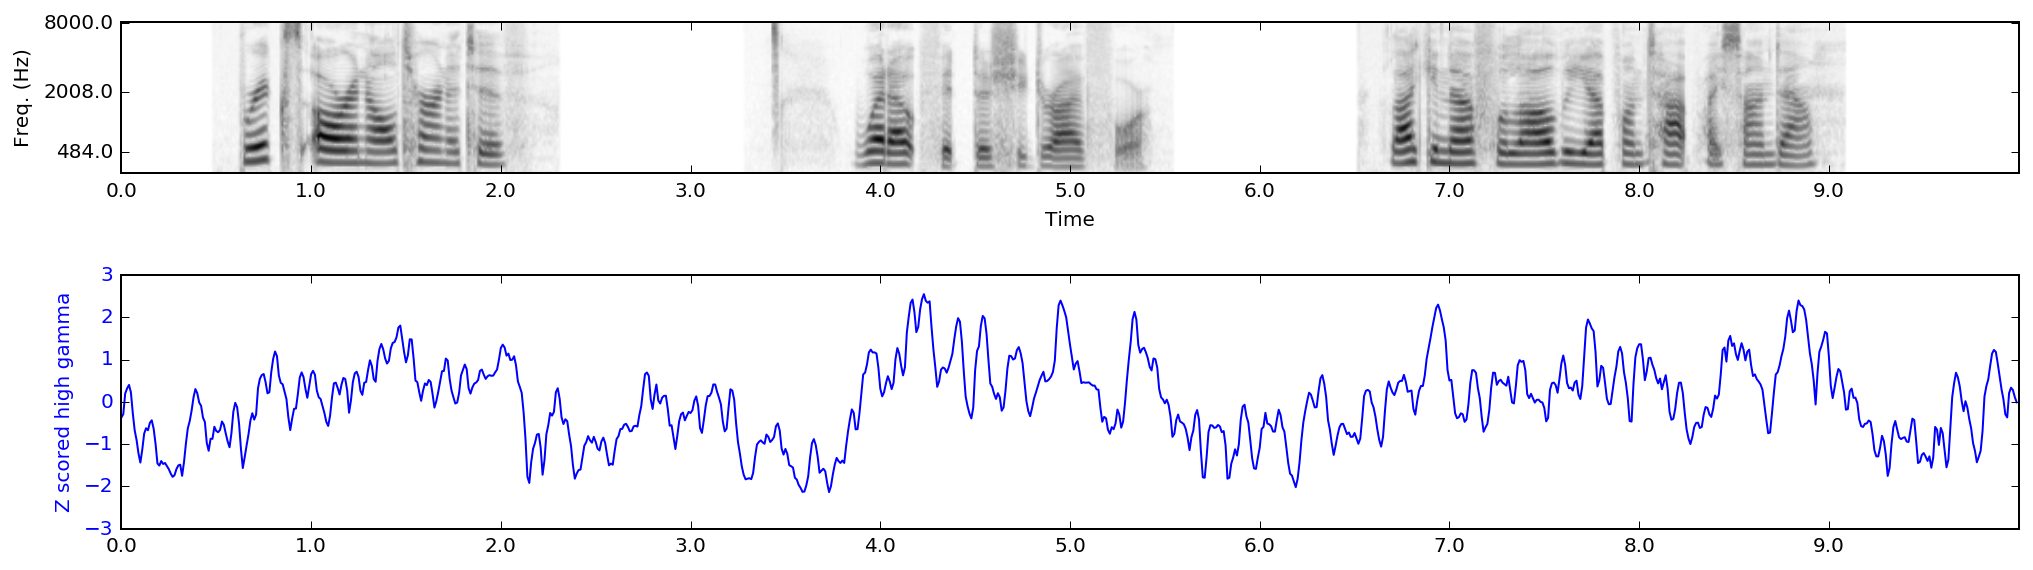

In [11]:
# Now we will show some sample data 
chan_to_plot = 30 # For sample data, also try 3, 7, 30

nsec = 10 # How many seconds of data to include in the plot
ntimes = np.int(nsec*fs) # How many time bins this is

fig = plt.figure(figsize=(17,5)) # make a figure of size 12 x 8
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(stim[:ntimes,:].T, cmap = cm.Greys) # I transposed the matrix so time is on the x axis
xlabel('Time')
ax1.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
ax1.set_ylabel('Freq. (Hz)')
yticks([11,43,79], [np.round(freqs[f]) for f in [11,43,79]])
xticks(np.arange(0,1000,fs), np.arange(0, 1000, fs)/fs)
ax1.set_xlim(0,ntimes)
ax1.set_ylim(0,stim.shape[1])

ax2 = fig.add_subplot(2,1,2)
ax2.plot(respz[:ntimes,chan_to_plot], 'b') 
ax2.set_ylabel('Z scored high gamma', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
xticks(np.arange(0,1000,fs), np.arange(0, 1000, fs)/fs)
ax2.set_xlim(0,ntimes);


## Create delay matrices

We now have the prerequisite matrices to perform our regression. For a model $Y = X B$, $X$ is our stimulus representation, $Y$ is the neural data, and $B$ are the weights that we are fitting.  However, we do not only want to look at how the instantaneous sound relates to the neural response -- we actually want to look at how sounds in the past influence the neural responses, so we must include time-delayed versions of the stimulus matrix in the model.   

One way to do this is to set up a stacked matrix of our stimulus at different time delays. This is called a [Toeplitz matrix](http://en.wikipedia.org/wiki/Toeplitz_matrix)). As a toy example, say we have a spectrogram with 3 frequencies and n time points.  Our stacked delay matrix would look something like this:

$$
\begin{bmatrix}
                x_{1,1} & x_{1,2} & x_{1,3} & \ldots & x_{1,n} & 0 & 0 & 0& \ldots & 0 \\
                x_{2,1} & x_{2,2} & x_{2,3} & \ldots & x_{2,n} & 0 & 0 & 0& \ldots & 0 \\
                x_{3,1} & x_{3,2} & x_{3,3} & \ldots & x_{3,n} & 0 & 0 & 0& \ldots & 0 \\
                0 & x_{1,1} & x_{1,2} & x_{1,3} & \ldots & x_{1,n} & 0 & 0& \ldots & 0 \\
                0 & x_{2,1} & x_{2,2} & x_{2,3} & \ldots & x_{2,n} & 0 & 0& \ldots & 0 \\
                0 & x_{3,1} & x_{3,2} & x_{3,3} & \ldots & x_{3,n} & 0 & 0& \ldots & 0 \\
                0 & 0 & x_{1,1} & x_{1,2} & x_{1,3} & \ldots & x_{1,n} & 0& \ldots & 0 \\
                0 & 0 & x_{2,1} & x_{2,2} & x_{2,3} & \ldots & x_{2,n} & 0& \ldots & 0 \\
                0 & 0 & x_{3,1} & x_{3,2} & x_{3,3} & \ldots & x_{3,n} & 0& \ldots & 0 \\
                \vdots & \vdots & \vdots & \vdots & \vdots & \ldots & \vdots & \vdots  & \ldots & 0 \\
                0 & \ldots & 0 & 0 & x_{1,1} & \ldots & x_{1,n-2} & x_{1,n-1} & x_{1,n} & \vdots \\
                0 & \ldots & 0 & 0 & x_{2,1} & \ldots & x_{2,n-2} & x_{2,n-1} & x_{2,n} & \vdots \\
                0 & \ldots & 0 & 0 & x_{3,1} & \ldots & x_{3,n-2} & x_{3,n-1} & x_{3,n} & \vdots \\
                0 & \ldots & 0 & 0 & 0 & x_{1,1} & \ldots & x_{1,n-2} & x_{1,n-1} & x_{1,n} \\
                0 & \ldots & 0 & 0 & 0 & x_{2,1} & \ldots & x_{2,n-2} & x_{2,n-1} & x_{2,n} \\
                0 & \ldots & 0 & 0 & 0 & x_{3,1} & \ldots & x_{3,n-2} & x_{3,n-1} & x_{3,n}
            \end{bmatrix}.
$$

Now let's look at what this actually looks like with our chosen stimulus representation.

In [12]:
print(stim.shape)

# First, choose the number of delays to use (remember this is in bins)
delay_time = 0.6 # In seconds, how far back in the past to look (more delays = more time, more weights to fit, slower)
delays = np.arange(np.floor(delay_time*fs), dtype=np.int) 

#delays = [0] # Fit only the instantaneous model
print("Delays:", delays)

# z-score the stimulus (if not a binary matrix, otherwise comment out)
zstim = zs(stim)

nt,ndim = zstim.shape # you could also replace all instances of "stim" here with "phnstim"
dstims = []
for di,d in enumerate(delays):
    dstim = np.zeros((nt, ndim))
    if d<0: ## negative delay
        dstim[:d,:] = zstim[-d:,:] # The last d elements until the end
    elif d>0:
        dstim[d:,:] = zstim[:-d,:] # All but the last d elements
    else:
        dstim = zstim.copy()
    dstims.append(dstim)
dstims = np.hstack(dstims)
print("Stimulus matrix is now %d time points by %d features (should be # original features \
(%d) x # delays (%d))"%(dstims.shape[0], dstims.shape[1], stim.shape[1], len(delays)))

(106299, 80)
Delays: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59]
Stimulus matrix is now 106299 time points by 4800 features (should be # original features (80) x # delays (60))


## Look at delayed stimulus matrix

Here I'll plot only a subset of the delayed matrix so you can see its structure. Again, this is transposed so that time is on the x axis. Red lines are shown so you can appreciate the small shifts of the matrices as a function of delay.

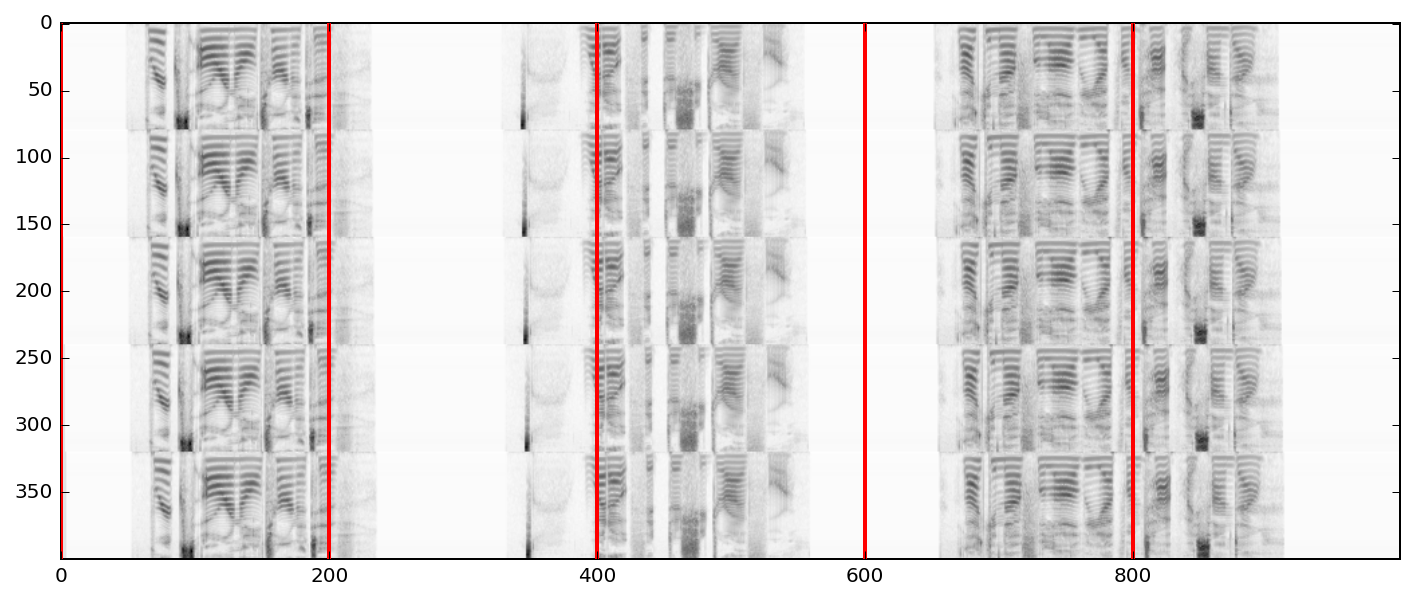

In [13]:
fig, axes = plt.subplots(figsize=(12,8))
imshow(dstims[:1000,:400].T, cmap = cm.Greys)
gca().xaxis.grid(b=True, which='major', color='r', linestyle='-', linewidth=2)

Here is the whole thing for comparison (still only the first 1000 time points, otherwise this plot is unwieldy.)  The delay structure is much easier to see here, but the fine structure of the individual spectrograms is gone.

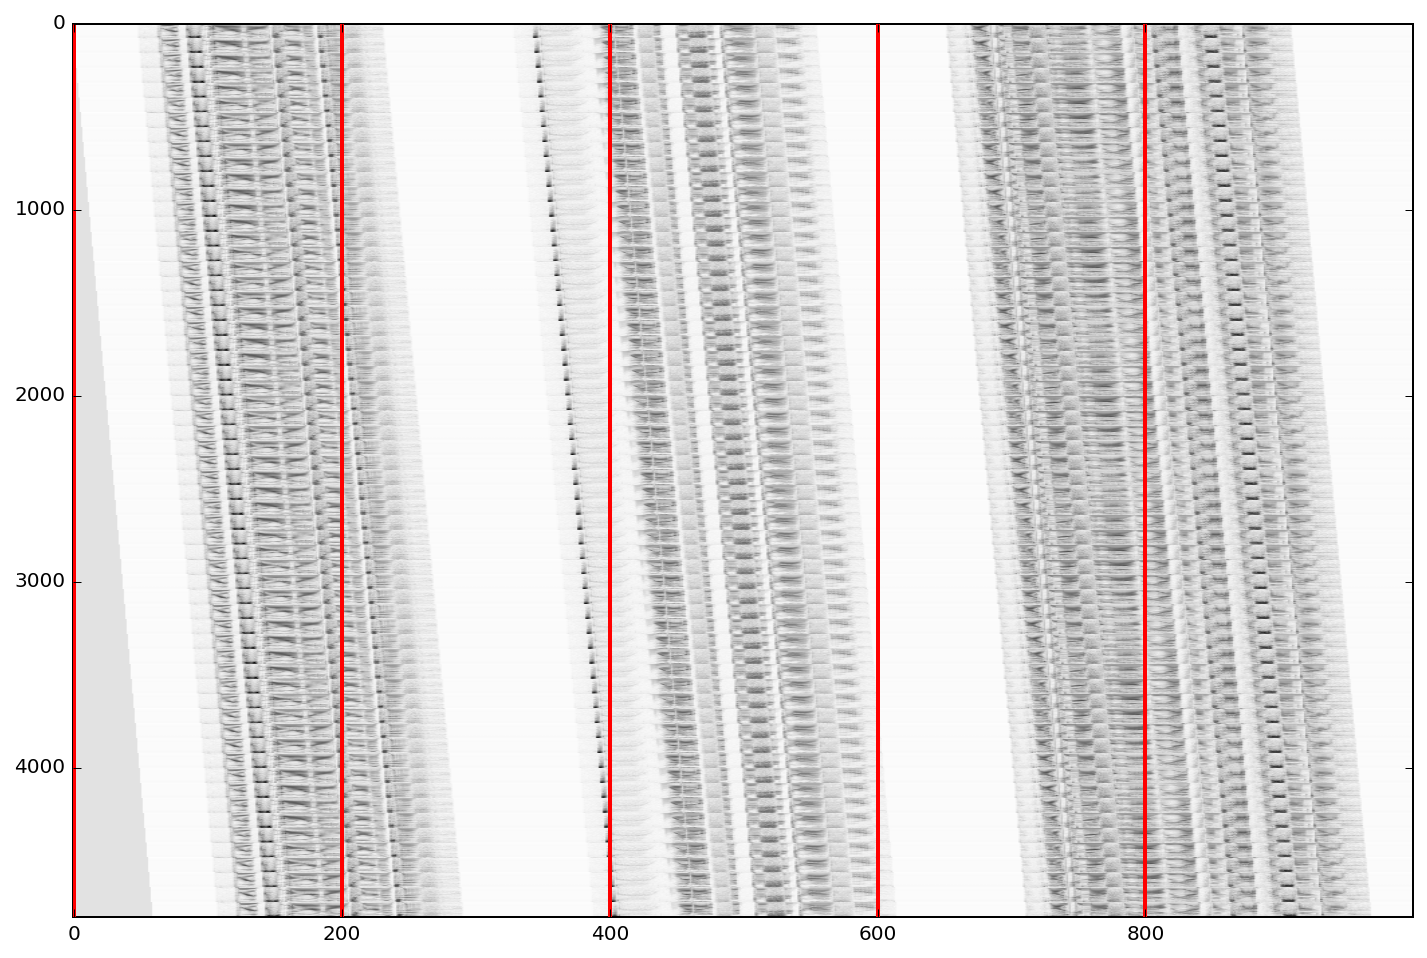

In [14]:
fig, axes = plt.subplots(figsize=(12,8))
imshow(dstims[:1000,:].T, cmap = cm.Greys, aspect='auto')
gca().xaxis.grid(b=True, which='major', color='r', linestyle='-', linewidth=2)

## Setting up the regression models - cross validation

Now that we have this stacked delay matrix, we split the data into chunks for cross validation -- 60% of the data is used for training, 20% to calculate the ridge parameter, and 20% for our final validation.  It is good practice to try different partitions of the data for training, ridge, and validation to determine the stability of your solution and to get bounds on the correlation coefficients.

In practice, you would want to do this for multiple splits of the data (for example, 10-fold cross validation).  However, if chunking the data, you do not want to take random samples of the data for training, ridge, and validation, because they will be highly correlated. It is better to randomize the data in chunks of several seconds to preserve the temporal structure in the training, ridge, and validation set.

In [15]:
# Training indices
train_inds = np.arange(np.int(nt*0.6))

# Ridge indices
ridge_inds = np.arange(np.int(nt*0.6),np.int(nt*0.8))

# Validation indices
val_inds = np.arange(np.int(nt*0.8),nt)

print("Delayed stimulus matrix has dimensions", dstims.shape)

# Create matrices for cross validation

# Training
tStim = dstims[train_inds,:]
tResp = resp[train_inds,:]
tResp_z = respz[train_inds,:]

# Ridge
rStim = dstims[ridge_inds,:]
rResp = resp[ridge_inds,:]
rResp_z = respz[ridge_inds,:]

# Validation
vStim = dstims[val_inds,:]
vResp = resp[val_inds,:]
vResp_z = respz[val_inds,:]

Delayed stimulus matrix has dimensions (106299, 4800)


## Covariance matrix

In most STRF analyses, we must normalize by autocorrelations in the stimulus (frequencies that always appear together, or temporal correlations that occur as a result of smoothly varying signals).  We do this by calculating the covariance of the delayed stimulus.  This will tell us which frequencies/features covary with one another in our stimulus, and how they covary across time (that is, is "f" often followed by "aa" 10 ms later?)

In [16]:
# Calculate covariance matrix for training data
dtype = np.single
covmat = np.array(np.dot(tStim.astype(dtype).T, tStim.astype(dtype)))

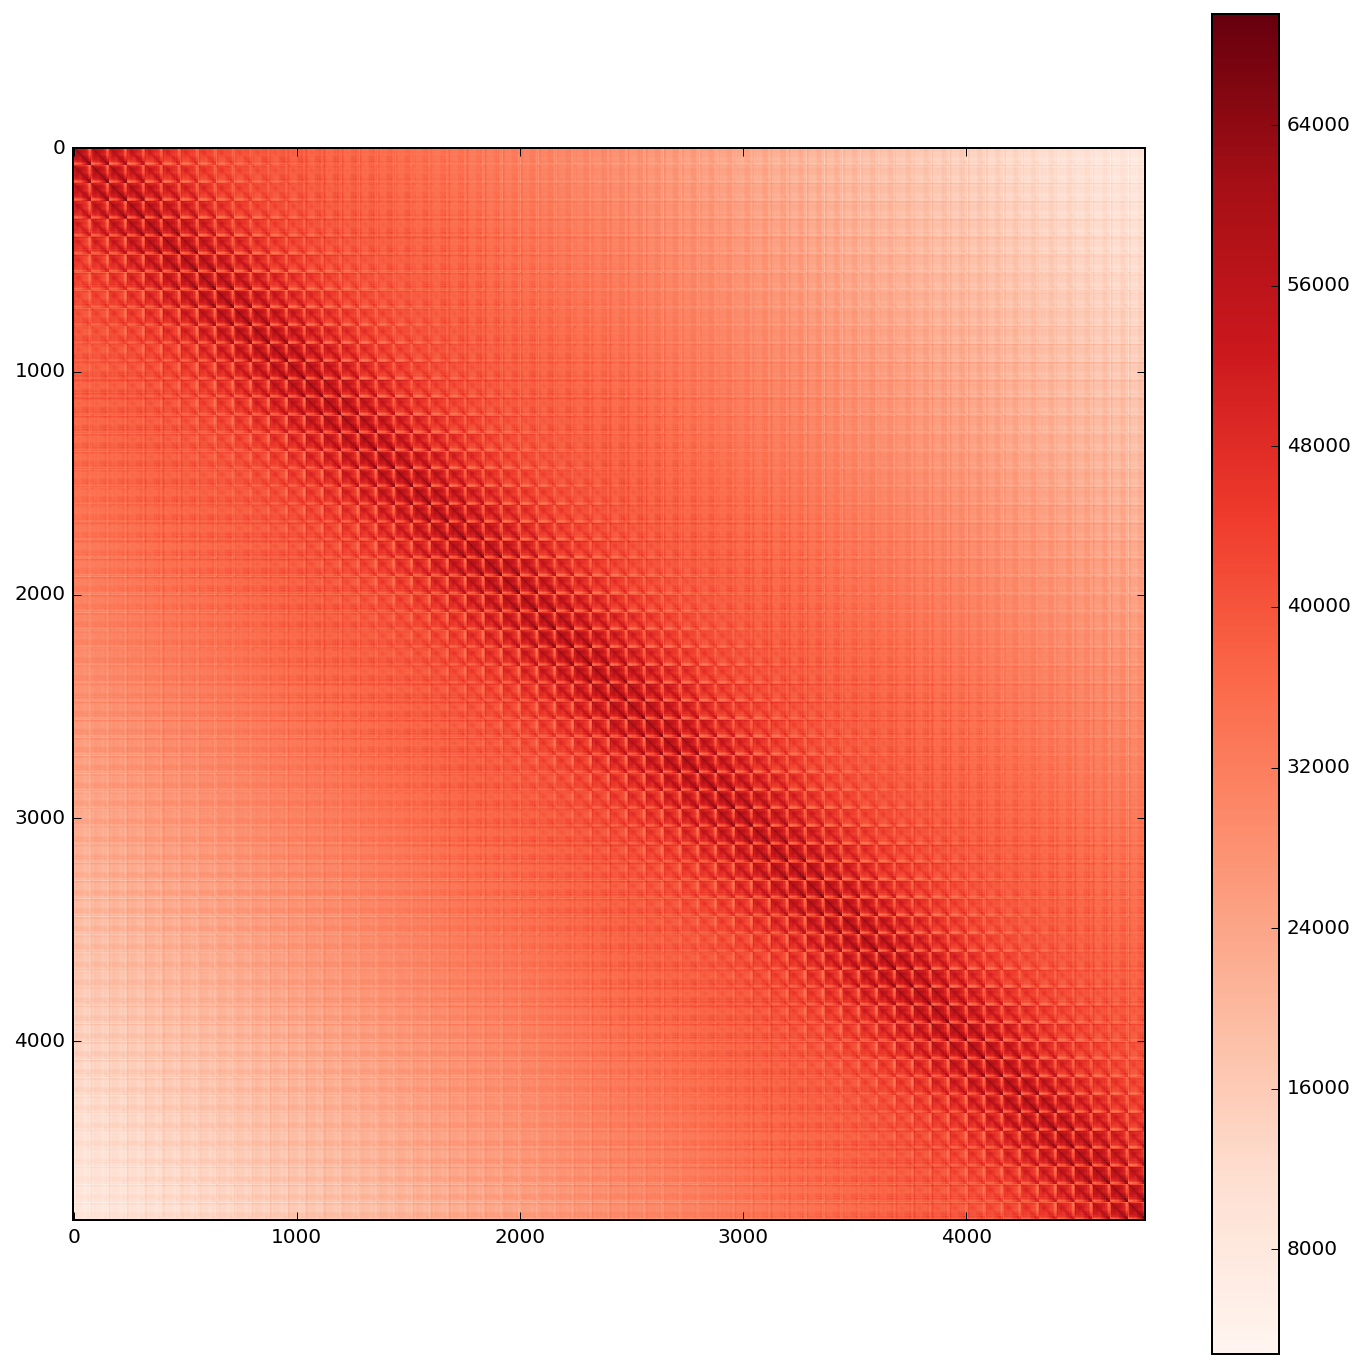

In [17]:
# Show covariance matrix
figure(figsize=(12,12))
imshow(covmat, cmap=cm.Reds)
colorbar()

## Question: How would you interpret this covariance matrix? ##

Describe the structure of it and what it means about correlations in the stimulus.

## Ridge Regression ##

Next, we will actually run the regression model with our new delayed stimulus matrix and our neural data. Since we are using ridge regression, we must choose a regularization parameter $\alpha$.  Normally this would be done by testing a large range of values and testing performance on the ridge set, then choosing the parameter that maximizes the correlation between your actual and predicted responses.

In [18]:
# Do eigenvalue decomposition on the covariance matrix
[S,U] = np.linalg.eigh(covmat)

# Store this multiplication for future use
Usr = np.dot(U.T, np.dot(tStim.T, tResp))

# Set the regularization values that you are going to test
# Usually this will be 0 (for no regularization), then some wide range of values.
# Here we're testing 15 values, log-spaced between 10^2 and 10^8
alphas = np.hstack((0,np.logspace(2,8,15)))
nalphas = len(alphas)

# Initialize list for spectrotemporal receptive field weights
wts = []
Rcorrs = []
bestcorr = -1.0
corrmin = 0.1

for i, a in enumerate(alphas):
    print("Running alpha %0.3f"%a)
    D = np.diag(1/(S+a)).astype(dtype)
    
    # Compute the weights
    wt = np.array(np.dot(U, np.dot(D, Usr)).astype(dtype))
    
    ## Predict test responses
    pred = np.dot(rStim, wt) # predicted response
    
    # calculate correlation between actual response in ridge set and predicted response
    Rcorr = np.array([np.corrcoef(rResp[:,ii], np.array(pred[:,ii]).ravel())[0,1] for ii in range(rResp.shape[1])])
    Rcorr[np.isnan(Rcorr)] = 0
    Rcorrs.append(Rcorr)
    
    wts.append(wt)
    print("Training: alpha=%0.3f, mean corr=%0.3f, max corr=%0.3f, over-under(%0.2f)=%d"%(a, np.mean(Rcorr), np.max(Rcorr), corrmin, (Rcorr>corrmin).sum()-(-Rcorr>corrmin).sum()))
    
# wts matrix is the matrix of STRFs for each alpha value
wts = np.array(wts)

# Rcorrs is the matrix of correlations on the ridge set
Rcorrs = np.array(Rcorrs)

print(Rcorrs.shape)
#plt.plot(Rcorrs)

Running alpha 0.000
Training: alpha=0.000, mean corr=0.260, max corr=0.640, over-under(0.10)=45
Running alpha 100.000
Training: alpha=100.000, mean corr=0.265, max corr=0.646, over-under(0.10)=45
Running alpha 268.270
Training: alpha=268.270, mean corr=0.270, max corr=0.651, over-under(0.10)=45
Running alpha 719.686
Training: alpha=719.686, mean corr=0.277, max corr=0.657, over-under(0.10)=47
Running alpha 1930.698
Training: alpha=1930.698, mean corr=0.285, max corr=0.663, over-under(0.10)=48
Running alpha 5179.475
Training: alpha=5179.475, mean corr=0.293, max corr=0.667, over-under(0.10)=49
Running alpha 13894.955
Training: alpha=13894.955, mean corr=0.301, max corr=0.669, over-under(0.10)=52
Running alpha 37275.937
Training: alpha=37275.937, mean corr=0.307, max corr=0.670, over-under(0.10)=53
Running alpha 100000.000
Training: alpha=100000.000, mean corr=0.311, max corr=0.669, over-under(0.10)=55
Running alpha 268269.580
Training: alpha=268269.580, mean corr=0.313, max corr=0.665, 

## Find the best alpha value to determine which regularization parameter to use ##

Correlation matrix shape: (16, 68)


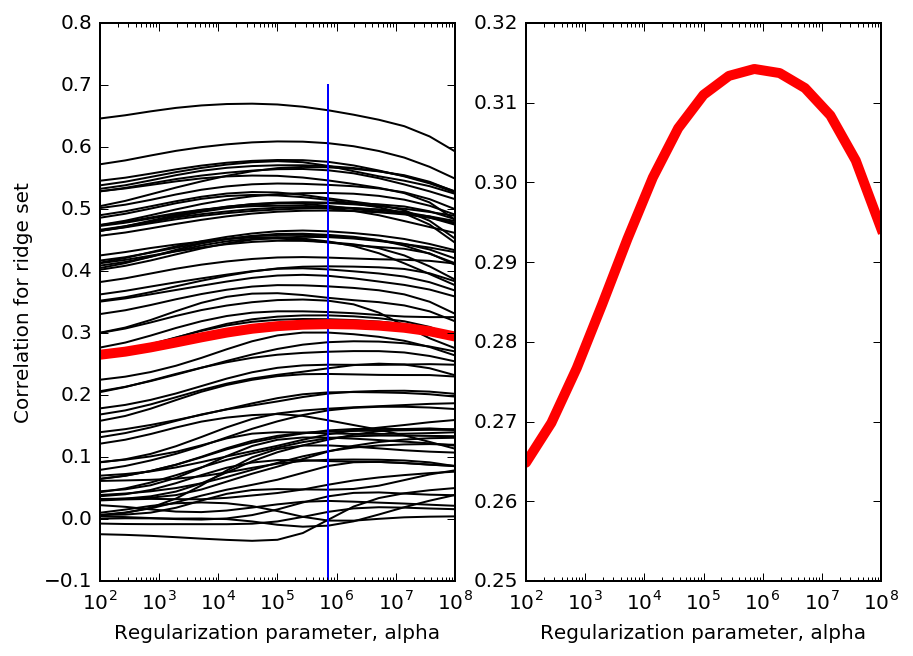

In [19]:
print("Correlation matrix shape:", Rcorrs.shape)

# Find the best alpha value to determine which regularization parameter should be used
best_alpha_overall = Rcorrs.mean(1).argmax() # Find the best alpha overall
best_alphas_indiv = Rcorrs.argmax(0) # Find the best alpha for each channel separately

# Plot correlations vs. alpha regularization value
fig=figure(figsize=(7,5))
fig.clf()
subplot(1,2,1)
plt.plot(alphas,Rcorrs,'k')
gca().set_xscale('log')

# Plot the best average alpha
plt.plot([alphas[best_alpha_overall], alphas[best_alpha_overall]],[ylim()[0],ylim()[1]])
plt.plot(alphas,np.array(Rcorrs).mean(1),'r',linewidth=5)
xlabel('Regularization parameter, alpha')
ylabel('Correlation for ridge set')

subplot(1,2,2)
plt.plot(alphas,np.array(Rcorrs).mean(1),'r',linewidth=5)
xlabel('Regularization parameter, alpha')
gca().set_xscale('log')


## Calculating performance on the validation set

Next, we need to calculate the predicted response to our validation set for our assessment of model performance.  Normally we would only do this for the best alpha found in the previous step, but here we will calculate all STRFs for all channels and all alphas so we can compare the correlations later.  The result will be a matrix `vPred` with dimensions (`feature weights` $\times$ `electrodes` $\times$ `alphas`)

In [20]:
print("Calculating predicted response to validation set")
wt_array = np.dstack(wts)
print(wt_array.shape)
vPred = [ [ vStim.dot(wt_array[:,ch,alph]) for ch in np.arange(nchans)] for alph in np.arange(nalphas)]
vPred = np.array(vPred)

Calculating predicted response to validation set
(4800, 68, 16)


In [21]:
print("Calculating correlations on validation set")
vcorr  = [ [ np.corrcoef(vPred[alph][ch], vResp[:,ch])[0,1] for ch in np.arange(nchans)] for alph in np.arange(nalphas)]
vcorr = np.array(vcorr)
print("Done calculating correlations")
print("Correlation matrix shape: ", vcorr.shape)

Calculating correlations on validation set
Done calculating correlations
Correlation matrix shape:  (16, 68)


## Plotting predicted vs. actual responses

Next, we will show a visualization of the best predicted neural responses for different regularization ($\alpha$) values.  Higher values of $\alpha$ will result in smoother, flatter responses.

Best electrode is channel 29 with r= 0.640257843041
Prediction matrix shape:  (16, 68, 21260)
Response matrix shape:  (21260, 68)


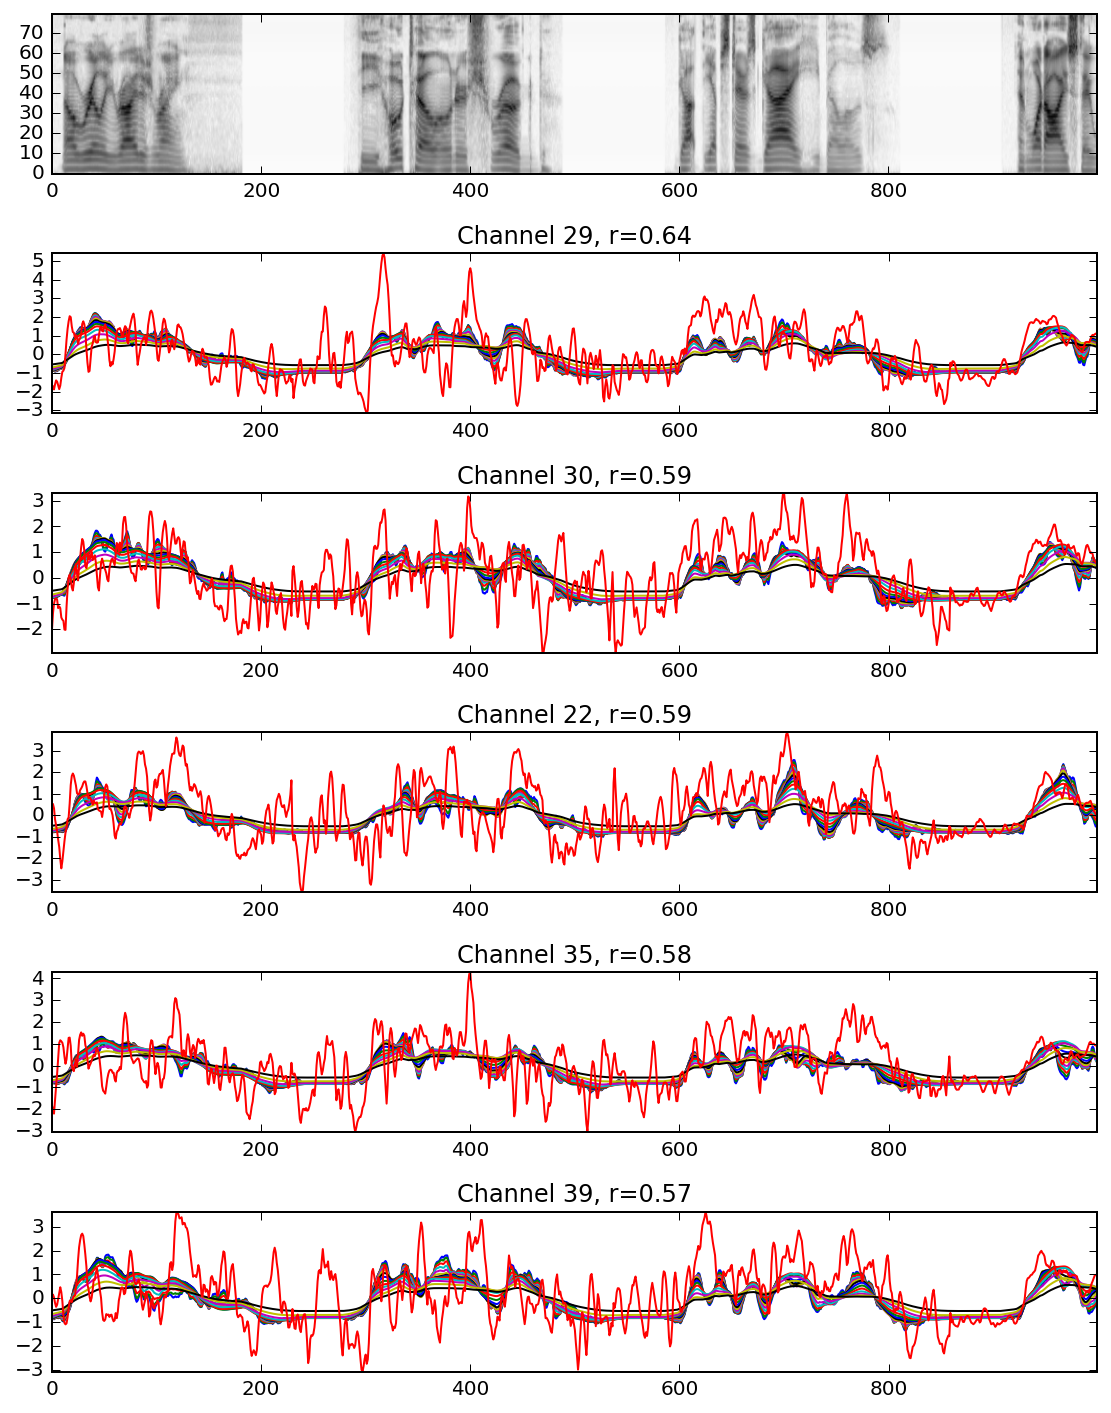

In [22]:
# Sort channels by highest validation correlation and plot the response predicted by the STRF 
# overlayed on the actual activity 
vcorr[np.isnan(vcorr)]=0
sorted_chans = vcorr.mean(0).argsort() # sort validation correlations by highest mean correlation across alpha value
best_chan = sorted_chans[-1]
print("Best electrode is channel", best_chan, "with r=", vcorr[:,best_chan].mean())

# Plot predictions vs. actual response
print("Prediction matrix shape: ", vPred.shape)
print("Response matrix shape: ", vResp.shape)

fig = figure(figsize=(8,10))
ax = subplot(6,1,1)
ax.imshow(vStim[:ntimes,0:80].T, aspect='auto', cmap=cm.Greys)
ax.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom

for i in np.arange(5):
    subplot(6,1,i+2)
    plot(vPred[2:,sorted_chans[-(i+1)],:ntimes].T)
    plot(vResp[:ntimes,sorted_chans[-(i+1)]],'r')
    title('Channel %d, r=%2.2f'%(sorted_chans[-(i+1)], vcorr[:,sorted_chans[-(i+1)]].mean()))
    axis('tight')
fig.tight_layout()


## Visualizing the STRF filters

Here we will show the STRF filters we've derived for each channel.  These filters show which spectrotemporal features of the stimulus best predict an increase or decrease in the observed neural activity.

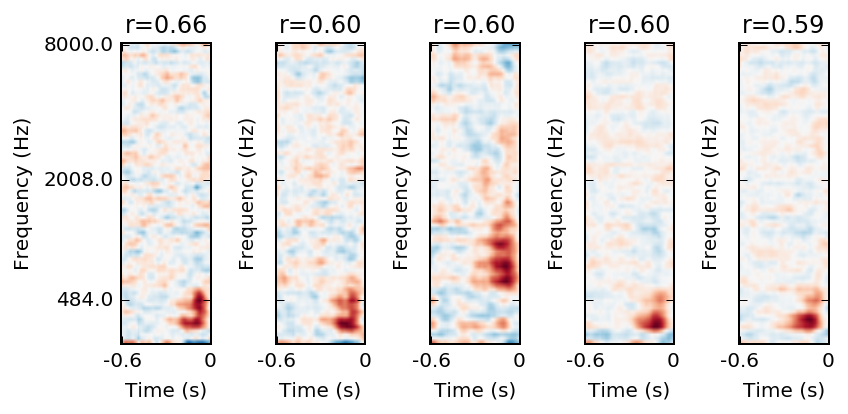

In [23]:
# Plot the STRFs using a separate regularization parameter for each (whichever gives the best performance)
nchans = 5 

if nchans>8:
    fsize=(15,15)
    nrow = np.sqrt(nchans)
    ncol = np.ceil(nchans/nrow)
else:
    fsize=(6,3)
    nrow = 1
    ncol = nchans

fig = figure(figsize=fsize)
delay_time = len(delays)/fs

# Use separate regularization parameters for each STRF
for c in np.arange(nchans):
    ax = subplot(nrow,ncol,c+1)
    chan = sorted_chans[-(c+1)]
    strf = wt_array[:, chan, best_alphas_indiv[chan]].reshape(len(delays),-1)
    smax = np.abs(strf).max()
    imshow(strf.T, vmin=-smax, vmax=smax, cmap = cm.RdBu_r, aspect='auto')
    ax.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
    ax.set_xlim(ax.get_xlim()[::-1]) # This reverses the x axis so we're looking at time instead of delay

    if c==0:
        yticks([11,43,79], [np.round(freqs[f]) for f in [11,43,79]])
    else:
        yticks([11,43,79], [])
    xticks([0,len(delays)-1], [0, -len(delays)/fs])
    xlabel('Time (s)')
    ylabel('Frequency (Hz)')

    title('r=%2.2f'%(vcorr[best_alphas_indiv[chan], chan]))
    axis('tight')
fig.tight_layout()


In [24]:
# Now do the same thing, but use the same regularization parameters for each STRF
# Hint: see "Find the best alpha value"

## How does the selection of $\alpha$ affect the observed STRF filters? ##

It is important to choose a range of $\alpha$ values and determine which yield the best predictions on held out data, since the regularization parameter itself can affect the structure of your STRF.

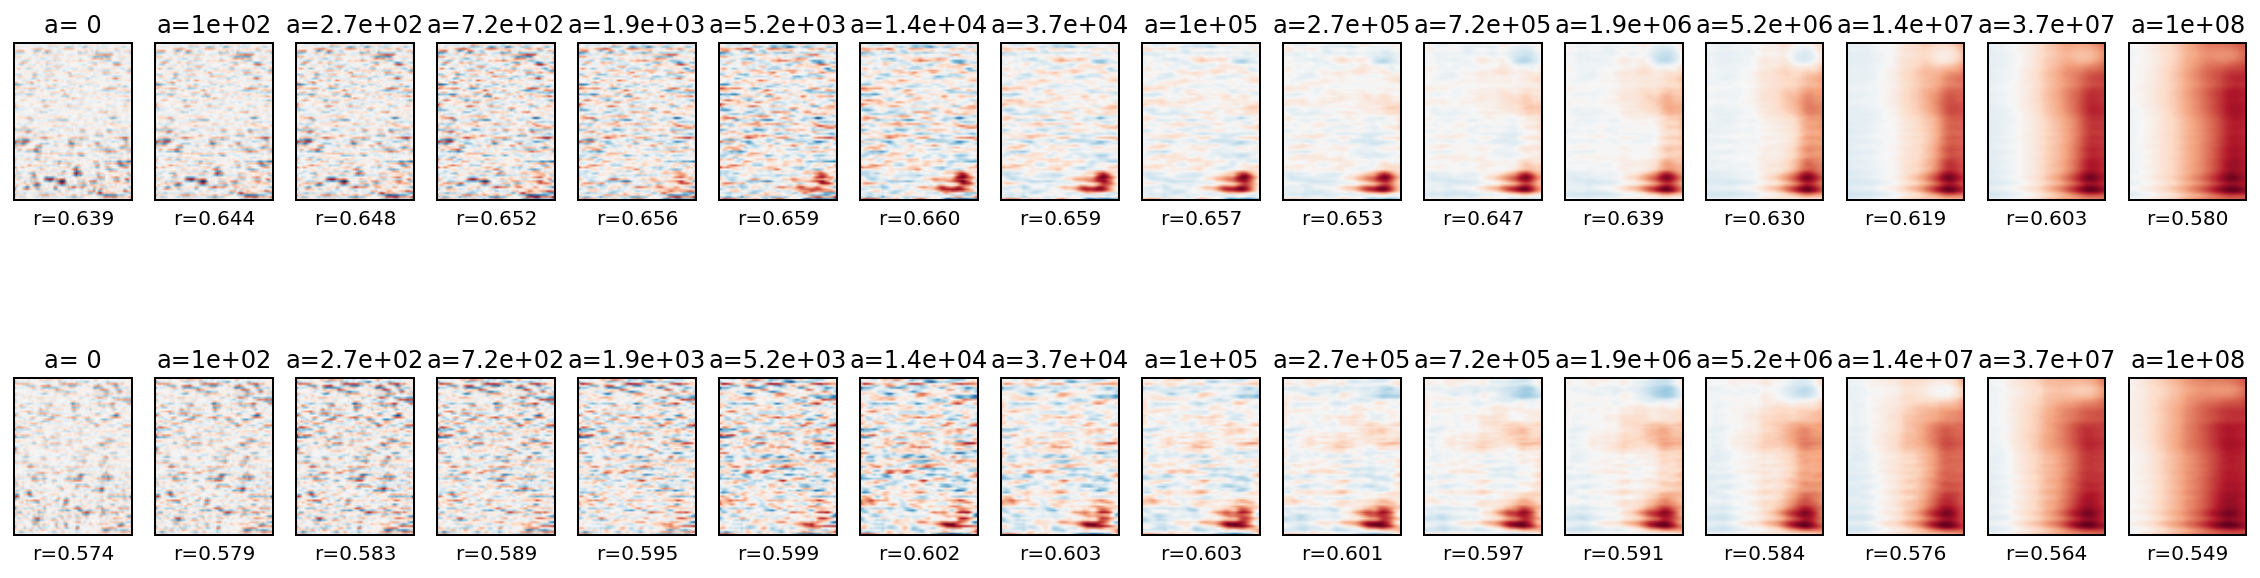

In [25]:
# Show how regularization parameter changes STRFs
fig = figure(figsize=(20,5))
fig.clf()
best_nchans = 2
axes = [fig.add_subplot(best_nchans,len(alphas),ii+1) for ii in range((len(alphas))*best_nchans)]
best_strf_inds = np.array(vcorr).mean(0).argsort()[::-1]
p = 0
for c in np.arange(best_nchans): # loop through the best channels
    ch = best_strf_inds[c]
    for a in np.arange(len(alphas)): # loop through the alpha regularization parameter
        strf = wt_array[:,ch,a].reshape(len(delays),-1)
        smax = np.abs(strf).max()
        axes[p].imshow(strf.T,vmin=-smax, vmax=smax, cmap = cm.RdBu_r) 
        axes[p].xaxis.set_ticks([])
        axes[p].yaxis.set_ticks([])
        axes[p].set_ylim(axes[p].get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
        axes[p].set_xlim(axes[p].get_xlim()[::-1]) # This reverses the x axis so we're looking at time instead of delay

        axes[p].set_xlabel('r=%2.3f'%(np.array(vcorr)[a,ch]))
        axes[p].set_title('a=%2.2g'%(alphas[a]))
        p+=1

fig.subplots_adjust(hspace=.5)
        

In [26]:
# Save the weights file
def save_table_file(filename, filedict):
    """Saves the variables in [filedict] in a hdf5 table file at [filename].
    """
    with tables.open_file(filename, mode="w", title="save_file") as hf:
        for vname, var in filedict.items():
            hf.create_array("/", vname, var)

wtfile = 'wts_%s.hf5'%(feature_type)
save_table_file(wtfile, dict(wts = wt_array, 
                             corrs = Rcorrs, 
                             vcorrs = vcorr, 
                             fs = fs, 
                             delays = delays, 
                             alphas = alphas))

print("Saved file to %s"%(wtfile))

Saved file to wts_spectrogram.hf5


## For you to try on your own ##

1. Replace the spectrotemporal representation with the phonetic feature or phoneme representation.  
2. How does the model performance (correlation coefficient) compare for spectrotemporal vs. phonetic feature vs. phonemes?
3. How does the best ridge parameter differ for each of these model types?
4. What if you change the number of delays in the model? How does this affect model performance and the appearance of the weight matrices? Is there a best number of delays that you can find for this dataset?
4. What about other models?  Could you calculate the performance of an acoustic envelope model?  A spectral change model (derivative of the spectrogram in different bands or across all bands)?  Any other models you can think of that might work? 